In [21]:
# Cell 1: Import libraries and set up environment
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, Descriptors, MACCSkeys, AllChem
from pubchempy import get_compounds
from IPython.display import display

In [22]:
# Cell 2: Find SMILES for verubecestat (MK-8931)
verubecestat = get_compounds('verubecestat', 'name')[0]
query_smiles = verubecestat.isomeric_smiles
print(f"SMILES for verubecestat: {query_smiles}")
query = Chem.MolFromSmiles(query_smiles)

SMILES for verubecestat: C[C@]1(CS(=O)(=O)N(C(=N1)N)C)C2=C(C=CC(=C2)NC(=O)C3=NC=C(C=C3)F)F


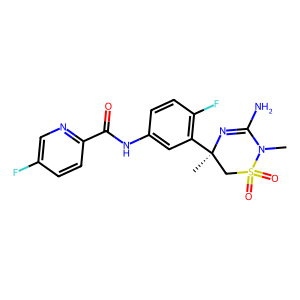

In [23]:
# Cell 3: Visualize the query molecule
img = Draw.MolToImage(query)
display(img)
img.save('verubecestat.png')

In [24]:
# Cell 4: Load the BACE1 dataset
bace1_dataset = pd.read_csv('../drug_design_2/ro5_properties_bace1_filtered.csv')
print(f"Number of molecules in dataset: {len(bace1_dataset)}")
bace1_dataset.head()

Number of molecules in dataset: 6078


,molecule_chembl_id,IC50,units,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,CHEMBL3969403,0.0002,nM,CC1(C)C(N)=N[C@](C)(c2cc(NC(=O)c3ccc(C#N)cn3)c...,12.698970,429.127089,7,2,2.12408,True
1,CHEMBL3937515,0.0009,nM,COc1cnc(C(=O)Nc2ccc(F)c([C@]3(C)CS(=O)(=O)C(C)...,12.045757,435.137653,8,2,1.65600,True
2,CHEMBL3949213,0.0010,nM,C[C@@]1(c2cc(NC(=O)c3ccc(C#N)cn3)ccc2F)CS(=O)(...,12.000000,455.142739,7,2,2.65828,True
3,CHEMBL3955051,0.0018,nM,CC1(C)C(N)=N[C@](C)(c2cc(NC(=O)c3cnc(C(F)F)cn3...,11.744727,455.123895,7,2,2.58500,True
4,CHEMBL3936264,0.0057,nM,C[C@@]1(c2cc(NC(=O)c3ccc(OC(F)F)cn3)ccc2F)CS(=...,11.244125,442.092261,7,2,2.07520,True


In [25]:
# Cell 5: Calculate molecular descriptors
def calculate_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return {
        'molecule_weight': Descriptors.MolWt(mol),
        'maccs': MACCSkeys.GenMACCSKeys(mol),
        'morgan': AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
    }

descriptors = bace1_dataset['smiles'].apply(calculate_descriptors)
bace1_dataset = pd.concat([bace1_dataset, pd.DataFrame(descriptors.tolist())], axis=1)

In [26]:
# Cell 6: Generate fingerprints for the query molecule
query_maccs = MACCSkeys.GenMACCSKeys(query)
query_morgan = AllChem.GetMorganFingerprintAsBitVect(query, 2, nBits=2048)

In [27]:
# Cell 7: Calculate molecular similarities
bace1_dataset["tanimoto_maccs"] = bace1_dataset['maccs'].apply(lambda x: DataStructs.TanimotoSimilarity(query_maccs, x))
bace1_dataset["tanimoto_morgan"] = bace1_dataset['morgan'].apply(lambda x: DataStructs.TanimotoSimilarity(query_morgan, x))
bace1_dataset["dice_maccs"] = bace1_dataset['maccs'].apply(lambda x: DataStructs.DiceSimilarity(query_maccs, x))
bace1_dataset["dice_morgan"] = bace1_dataset['morgan'].apply(lambda x: DataStructs.DiceSimilarity(query_morgan, x))

In [28]:
# Cell 8: Display top similar compounds
top_similar = bace1_dataset.sort_values("tanimoto_morgan", ascending=False).head(10)
print(top_similar[["smiles", "tanimoto_maccs", "tanimoto_morgan", "dice_maccs", "dice_morgan"]])

                                                 smiles  tanimoto_maccs  \
327   CN1C(N)=N[C@](C)(c2cc(NC(=O)c3ccc(F)cn3)ccc2F)...        1.000000   
1122    C[C@@]1(c2cc(NC(=O)c3ccc(F)cn3)ccc2F)CCSC(N)=N1        0.607595   
168   CC1(C)C(N)=N[C@](C)(c2cc(NC(=O)c3ccc(Cl)cn3)cc...        0.835443   
5     C[C@@]1(c2cc(NC(=O)c3ccc(Cl)cn3)ccc2F)CS(=O)(=...        0.768293   
1051  CN1CC[C@@](C)(c2cc(NC(=O)c3ccc(Cl)cn3)ccc2F)N=C1N        0.634146   
1197  C[C@@]1(c2cc(NC(=O)c3ccc(F)cn3)ccc2F)CC[C@@](C...        0.759036   
0     CC1(C)C(N)=N[C@](C)(c2cc(NC(=O)c3ccc(C#N)cn3)c...        0.848101   
985   C[C@]1(F)COC(N)=N[C@]1(C)c1cc(NC(=O)c2ccc(F)cn...        0.575000   
6     C[C@@]1(c2cc(NC(=O)c3ccc(C#N)cn3)ccc2F)CS(=O)(...        0.780488   
1029  C[C@@]1(c2cc(NC(=O)c3ccc(F)cn3)ccc2F)Cn2c(C#N)...        0.554217   

      tanimoto_morgan  dice_maccs  dice_morgan  
327          1.000000    1.000000     1.000000  
1122         0.630769    0.755906     0.773585  
168          0.621212    0.

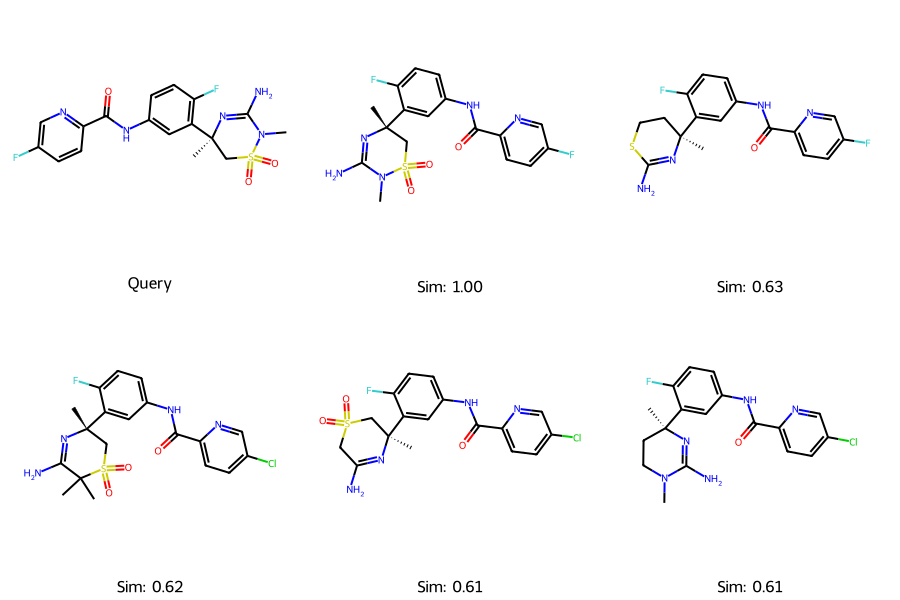

In [30]:
# Cell 9: Visualize top similar compounds
top_mols = [query] + [Chem.MolFromSmiles(smi) for smi in top_similar["smiles"][:5]]
legends = ["Query"] + [f"Sim: {sim:.2f}" for sim in top_similar["tanimoto_morgan"][:5]]
img = Draw.MolsToGridImage(top_mols, molsPerRow=3, subImgSize=(300,300), legends=legends)
display(img)

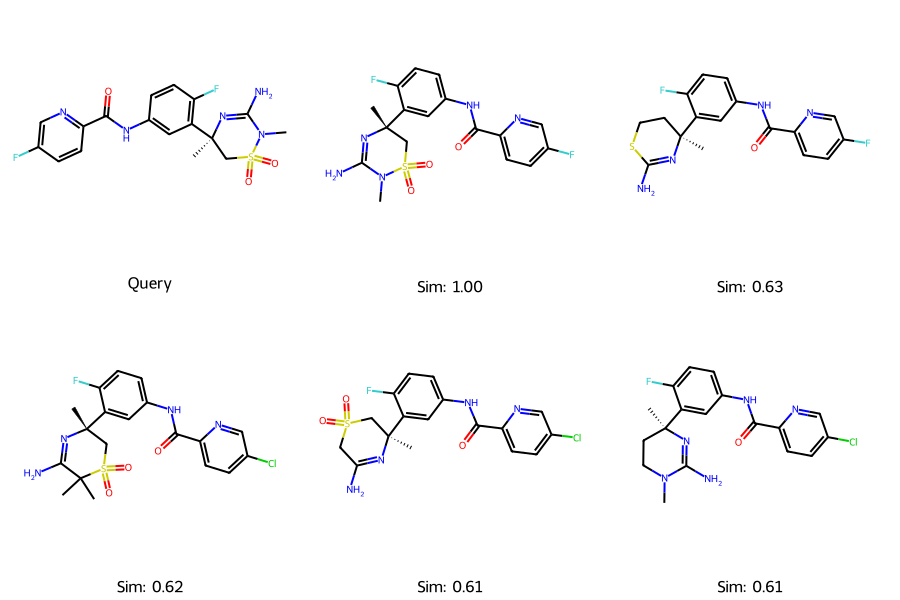

In [15]:
from rdkit import Chem
from rdkit.Chem import Draw
from PIL import Image
import io

# Cell 9: Visualize top similar compounds
top_mols = [query] + [Chem.MolFromSmiles(smi) for smi in top_similar["smiles"][:5]]
legends = ["Query"] + [f"Sim: {sim:.2f}" for sim in top_similar["tanimoto_morgan"][:5]]

# Create the grid image
img = Draw.MolsToGridImage(top_mols, molsPerRow=3, subImgSize=(300,300), legends=legends)

# Display the image in the notebook
display(img)

# Save the image to a file
#img.save('top_5_similar_bace1_inhibitors.png')

# If you need to work with the image as a PIL Image object:
pil_img = Image.open(io.BytesIO(img.data))
# Now you can use PIL methods on pil_img if needed
pil_img.save('top_5_similar_bace1_inhibitors_pil.png')

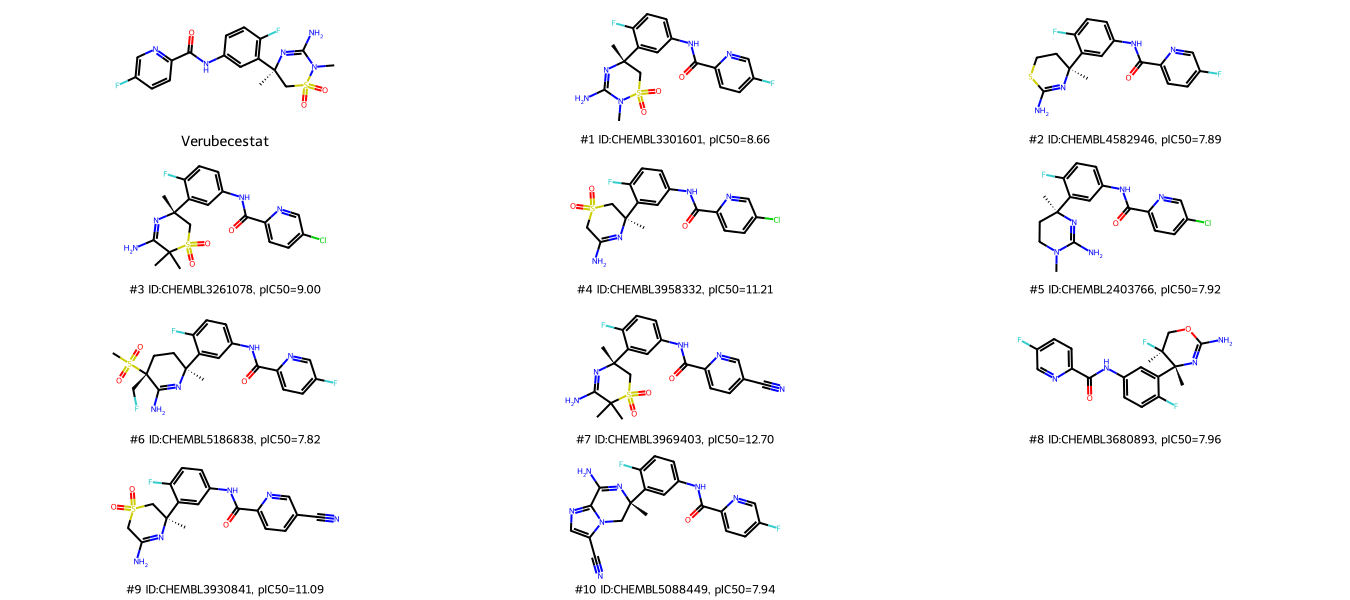

The top ranked molecules for Verubecestat are displayed above.
We can observe the structural similarities and variations among these top hits.


In [32]:
# Cell 10: Visualize most similar molecules with pIC50
top_n_molecules = 10
top_molecules = bace1_dataset.sort_values(["tanimoto_morgan"], ascending=False).reset_index(drop=True)
top_molecules = top_molecules[:top_n_molecules]

legends = [
    f"#{index+1} ID:{molecule['molecule_chembl_id']}, pIC50={molecule['pIC50']:.2f}"
    for index, molecule in top_molecules.iterrows()
]

mols = [query] + [Chem.MolFromSmiles(smiles) for smiles in top_molecules["smiles"]]
img = Draw.MolsToGridImage(
    mols=mols,
    legends=(["Verubecestat"] + legends),
    molsPerRow=3,
    subImgSize=(450, 150),
)

display(img)
print("The top ranked molecules for Verubecestat are displayed above.")
print("We can observe the structural similarities and variations among these top hits.")

In [33]:
# Cell 11: Define function for enrichment data
def get_enrichment_data(molecules, similarity_measure, pic50_cutoff):
    molecules_all = len(molecules)
    actives_all = sum(molecules["pIC50"] >= pic50_cutoff)
    actives_counter_list = []
    actives_counter = 0
    
    molecules = molecules.sort_values([similarity_measure], ascending=False)
    
    for value in molecules["pIC50"]:
        if value >= pic50_cutoff:
            actives_counter += 1
        actives_counter_list.append(actives_counter)
    
    molecules_percentage_list = [i / molecules_all for i in range(1, molecules_all + 1)]
    actives_percentage_list = [i / actives_all for i in actives_counter_list]
    
    enrichment = pd.DataFrame({
        "% ranked dataset": molecules_percentage_list,
        "% true actives identified": actives_percentage_list,
    })
    
    return enrichment

In [34]:
# Cell 12: Calculate enrichment data
pic50_cutoff = 6.3  # Commonly used cutoff for BACE1 inhibitors
similarity_measures = ["tanimoto_maccs", "tanimoto_morgan"]
enrichment_data = {
    similarity_measure: get_enrichment_data(bace1_dataset, similarity_measure, pic50_cutoff)
    for similarity_measure in similarity_measures
}

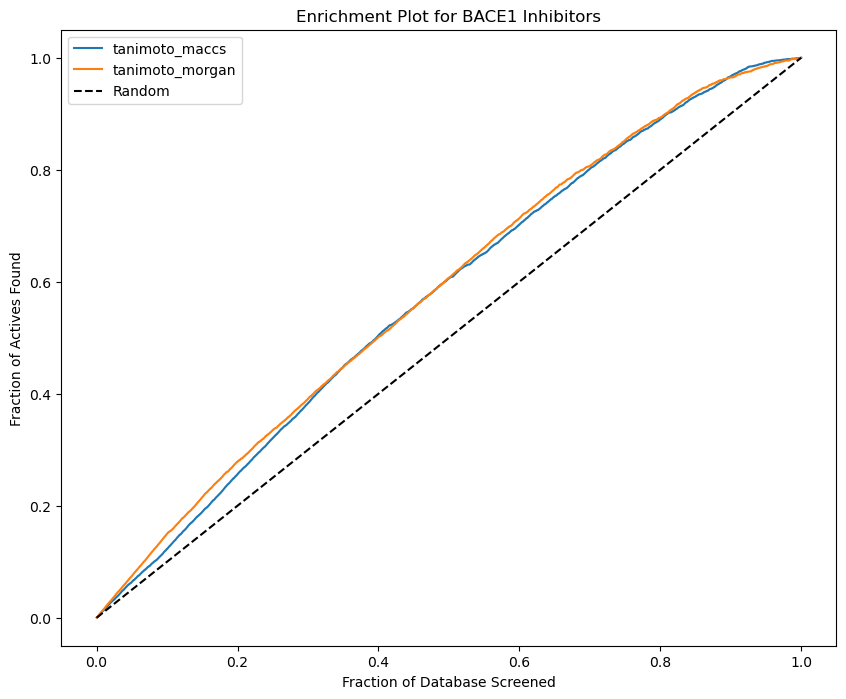

In [35]:
# Cell 13: Plot enrichment curves
plt.figure(figsize=(10, 8))
for similarity_measure, enrichment in enrichment_data.items():
    plt.plot(enrichment["% ranked dataset"], enrichment["% true actives identified"], label=similarity_measure)

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('Fraction of Database Screened')
plt.ylabel('Fraction of Actives Found')
plt.title('Enrichment Plot for BACE1 Inhibitors')
plt.legend()
plt.savefig('bace1_enrichment_plot.png')
plt.show()

In [36]:
# Cell 14: Define functions for enrichment factor calculations
def calculate_enrichment_factor(enrichment, ranked_dataset_percentage_cutoff):
    enrichment = enrichment[enrichment["% ranked dataset"] <= ranked_dataset_percentage_cutoff / 100]
    highest_enrichment = enrichment.iloc[-1]
    enrichment_factor = round(100 * float(highest_enrichment["% true actives identified"]), 1)
    return enrichment_factor

def calculate_enrichment_factor_random(ranked_dataset_percentage_cutoff):
    return round(float(ranked_dataset_percentage_cutoff), 1)

def calculate_enrichment_factor_optimal(molecules, ranked_dataset_percentage_cutoff, pic50_cutoff):
    ratio = sum(molecules["pIC50"] >= pic50_cutoff) / len(molecules) * 100
    if ranked_dataset_percentage_cutoff <= ratio:
        enrichment_factor_optimal = round(100 / ratio * ranked_dataset_percentage_cutoff, 1)
    else:
        enrichment_factor_optimal = 100.0
    return enrichment_factor_optimal


In [37]:
# Cell 15: Calculate and display enrichment factors
ranked_dataset_percentage_cutoff = 5

for similarity_measure, enrichment in enrichment_data.items():
    ef = calculate_enrichment_factor(enrichment, ranked_dataset_percentage_cutoff)
    print(f"Experimental EF for {ranked_dataset_percentage_cutoff}% of ranked dataset ({similarity_measure}): {ef}%")

ef_random = calculate_enrichment_factor_random(ranked_dataset_percentage_cutoff)
print(f"Random EF for {ranked_dataset_percentage_cutoff}% of ranked dataset: {ef_random}%")

ef_optimal = calculate_enrichment_factor_optimal(bace1_dataset, ranked_dataset_percentage_cutoff, pic50_cutoff)
print(f"Optimal EF for {ranked_dataset_percentage_cutoff}% of ranked dataset: {ef_optimal}%")


Experimental EF for 5% of ranked dataset (tanimoto_maccs): 6.4%
Experimental EF for 5% of ranked dataset (tanimoto_morgan): 7.4%
Random EF for 5% of ranked dataset: 5.0%
Optimal EF for 5% of ranked dataset: 8.1%


# BACE1 Inhibitor Analysis: Virtual Screening and Enrichment

## Introduction

In this notebook, we've performed a virtual screening analysis of potential BACE1 inhibitors, using **Verubecestat** as our query molecule. BACE1 (Beta-secretase 1) is a key enzyme in the pathogenesis of Alzheimer's disease, making it an important target for drug discovery efforts.

## Methodology

### 1. Data Preparation and Molecule Representation

We started by loading our BACE1 dataset and representing molecules using SMILES strings. This standardized format allows for efficient storage and manipulation of molecular structures.

### 2. Molecular Descriptors and Fingerprints

We calculated two types of molecular fingerprints:
- MACCS (Molecular ACCess System) keys
- Morgan fingerprints (similar to Extended-Connectivity Fingerprints)

These fingerprints encode structural information about molecules in a way that allows for rapid similarity comparisons. MACCS keys are based on a predefined set of structural features, while Morgan fingerprints capture circular substructures around each atom.

### 3. Similarity Calculations

We used two similarity metrics:
- Tanimoto coefficient
- Dice coefficient

These metrics quantify the structural similarity between molecules based on their fingerprints. The Tanimoto coefficient is widely used in cheminformatics and provides a good balance between sensitivity and specificity.

### 4. Virtual Screening

We ranked the molecules in our dataset based on their similarity to verubecestat.

The principle of similar property states that structurally similar molecules are likely to have similar properties. By identifying compounds similar to a known BACE1 inhibitor, we aim to find other potential inhibitors.

### 5. Visualization of Similar Compounds

We visualized the top similar compounds to **Verubecestat**.

This allows for a quick, intuitive assessment of the structural features that contribute to BACE1 inhibition and helps identify any patterns or unexpected results in our similarity search.

### 6. Enrichment Analysis

We generated enrichment plots and calculated enrichment factors.

Enrichment analysis helps us assess how well our virtual screening method performs compared to random selection. It quantifies our method's ability to identify active compounds early in the ranked list.

## Limitations

1. This approach is biased towards compounds structurally similar to **Verubecestat** and may miss novel scaffolds with BACE1 inhibitory activity.
2. We don't account for 3D structural information or protein-ligand interactions, which are crucial for binding.
3. The binary classification of compounds as active/inactive based on a pIC50 threshold is a simplification of the continuous nature of biological activity.

## Possible Next Steps

1. **Pharmacophore Modeling**: Develop a pharmacophore model based on known BACE1 inhibitors to capture key features required for activity.

2. **Machine Learning Models**: Train ML models (e.g., Random Forests, SVMs, or Neural Networks) to predict BACE1 inhibition based on molecular descriptors.

3. **Docking Studies**: Perform molecular docking of top hits into the BACE1 active site to assess their binding modes and energies.

4. **Scaffold Hopping**: Use the insights gained to design novel scaffolds that maintain key interaction features but have diverse core structures.

5. **QSAR Analysis**: Develop quantitative structure-activity relationship models to understand which molecular features contribute most to BACE1 inhibition.

6. **Experimental Validation**: Propose the top-ranked compounds for synthesis and biological testing to validate the virtual screening results.